# 线性SVM：软间隔
----------------------------------

该脚本展示如何使用TensorFlow来创建一个软间隔SVM。

这里我们使用iris数据集：

$x_1 =$ Sepal Length

$x_2 =$ Petal Width

Class 1 : `I. setosa`

Class -1: `not I. setosa`

对于I.setosa分类问题，我们知道x,y数据是线性可分的。（但是有少量不怎么懂事的点跑错边了）。

>注意到我们使用一个数据点的允许误差边界来实现软边界。误差边界项伴随一个'alpha'参数。如果要得到硬边界SVM，只需要将alpha=0即可。（在notebook代码块#7）

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()

/home/zhangxin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
np.random.seed(42)
tf.set_random_seed(42)
sess = tf.Session()

In [3]:
# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y == 0 else -1 for y in iris.target])

In [4]:
train_indices = np.random.choice(len(x_vals),
                                 round(len(x_vals)*0.8),
                                 replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [5]:
# 批数据尺寸
batch_size = 120

# 占位符
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# 变量
A = tf.Variable(tf.random_normal(shape=[2, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))

声明我么的模型和L2范数正则化项

SVM线性模型如下：

$$\left[ \frac{1}{n} \sum_{i=1}^{n} \max(0, 1 - A \cdot x - b) \right] + \alpha \cdot ||A||^{2}$$

我们的损失函数如上所示，并且使用TensorFlow来最小化它。注意到$n$是数据点的数量（一批数据），$A$是正则化超平面向量（需要求解），$b$是超平面的偏移值（需要求解），并且$\alpha$是软边界参数。

In [6]:
# 声明模型运算
# 这里用tf.subtract和tf.add没有影响，因为b就是基于均值0，方差为1的分布来优化的，
# 其随机的正负不就是这里我们随机的tf.subtract和tf.add吗？
# model_output = tf.subtract(tf.matmul(x_data, A), b)
model_output = tf.add(tf.matmul(x_data, A), b)

# 声明向量L2范数
l2_norm = tf.reduce_sum(tf.square(A))

这里我们基于分类点来创建我们的损失函数。

注意到`alpha`是软边界项，并且如果其增大，则允许更多的分类误差点。对于应边界SVM，将`alpha=0`。

In [7]:
# 声明损失函数
# Loss = max(0, 1-pred*actual) + alpha * L2_norm(A)^2
# L2正则化参数，alpha

alpha = tf.constant([0.01])

# 损失函数中的边界项
classification_term = tf.reduce_mean(tf.maximum(0., 
                                                tf.subtract(1., 
                                                            tf.multiply(model_output, 
                                                                        y_target))))

# 将所有子项合起来
loss = tf.add(classification_term, tf.multiply(alpha, l2_norm))

创建预测函数，优化算法和初始化变量

In [8]:
# 声明预测函数
prediction = tf.sign(model_output)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, y_target), tf.float32))

# 优化器
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

# 变量初始化
init = tf.global_variables_initializer()
sess.run(init)

In [9]:
# 开始训练喽！
loss_vec = []
train_accuracy = []
test_accuracy = []
for i in range(500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)

    train_acc_temp = sess.run(accuracy, feed_dict={
        x_data: x_vals_train,
        y_target: np.transpose([y_vals_train])})
    train_accuracy.append(train_acc_temp)

    test_acc_temp = sess.run(accuracy, feed_dict={
        x_data: x_vals_test,
        y_target: np.transpose([y_vals_test])})
    test_accuracy.append(test_acc_temp)

    if (i + 1) % 100 == 0:
        print('Step #{} A = {}, b = {}'.format(
            str(i+1),
            str(sess.run(A)),
            str(sess.run(b))
        ))
        print('Loss = ' + str(temp_loss))

Step #100 A = [[ 0.3728633]
 [-2.6268818]], b = [[-0.02966844]]
Loss = [0.11915715]
Step #200 A = [[ 0.36604434]
 [-2.6193407 ]], b = [[-0.0230851]]
Loss = [0.09787891]
Step #300 A = [[ 0.3608879]
 [-2.612368 ]], b = [[-0.01591844]]
Loss = [0.12106016]
Step #400 A = [[ 0.36175305]
 [-2.6046946 ]], b = [[-0.00750178]]
Loss = [0.09086722]
Step #500 A = [[ 0.3599056]
 [-2.5995502]], b = [[0.00074823]]
Loss = [0.11230972]


In [10]:
# 得到系数
[[a1], [a2]] = sess.run(A)
[[b]] = sess.run(b)
slope = -a2/a1
y_intercept = b/a1

# 得到x1和x2值
x1_vals = [d[1] for d in x_vals]

# 得到最有分割曲线
best_fit = []
for i in x1_vals:
    best_fit.append(slope*i+y_intercept)

# 分类I. setosa
setosa_x = [d[1] for i, d in enumerate(x_vals) if y_vals[i] == 1]
setosa_y = [d[0] for i, d in enumerate(x_vals) if y_vals[i] == 1]
not_setosa_x = [d[1] for i, d in enumerate(x_vals) if y_vals[i] == -1]
not_setosa_y = [d[0] for i, d in enumerate(x_vals) if y_vals[i] == -1]

画图

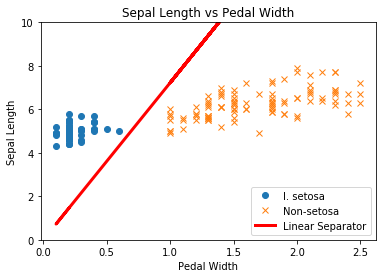

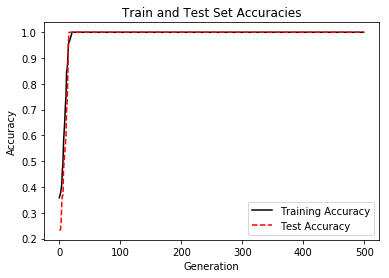

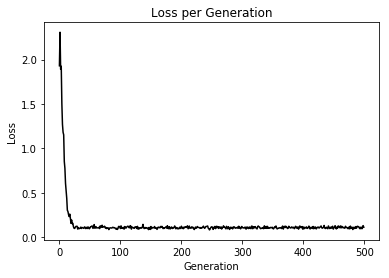

In [11]:
%matplotlib inline
# 画数据和分割线
plt.plot(setosa_x, setosa_y, 'o', label='I. setosa')
plt.plot(not_setosa_x, not_setosa_y, 'x', label='Non-setosa')
plt.plot(x1_vals, best_fit, 'r-', label='Linear Separator', linewidth=3)
plt.ylim([0, 10])
plt.legend(loc='lower right')
plt.title('Sepal Length vs Pedal Width')
plt.xlabel('Pedal Width')
plt.ylabel('Sepal Length')
plt.show()

# 画出训练/验证准确率
plt.plot(train_accuracy, 'k-', label='Training Accuracy')
plt.plot(test_accuracy, 'r--', label='Test Accuracy')
plt.title('Train and Test Set Accuracies')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()